In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
size = np.int(1e4)
sns.set(style="darkgrid")

normal_dict = {'N(0,1)':np.random.normal(0,1,size),'N(2,1)':np.random.normal(4,1,size),'N(0,5)':np.random.normal(0,5,size),
       'N(4,2)':np.random.normal(4,2,size),'N(2,3)':np.random.normal(2,3,size),'N(-1,5)':np.random.normal(-1,5,size)}
df = pd.DataFrame(normal_dict)
df.head(5)

,"N(0,1)","N(2,1)","N(0,5)","N(4,2)","N(2,3)","N(-1,5)"
0,-1.066385,4.850347,11.976527,4.478668,0.702854,-1.210409
1,-1.072741,4.128626,0.993680,5.553522,0.348919,-0.963100
2,0.202247,5.876780,-5.918207,3.397224,2.543001,1.102445
3,-0.209284,3.194024,0.544109,4.444767,3.389086,-4.840481
4,-0.753686,1.984288,1.123850,6.827098,6.965800,2.732630


In [62]:
def draw(data, bins, _cumulative=False):
    
    df_melted = pd.melt(data, value_vars = data.columns)
    
    g = sns.FacetGrid(data = df_melted,  col = "variable", col_wrap = 3, sharex = False)
    g = g.map(plt.hist, "value", bins=bins, cumulative=_cumulative)

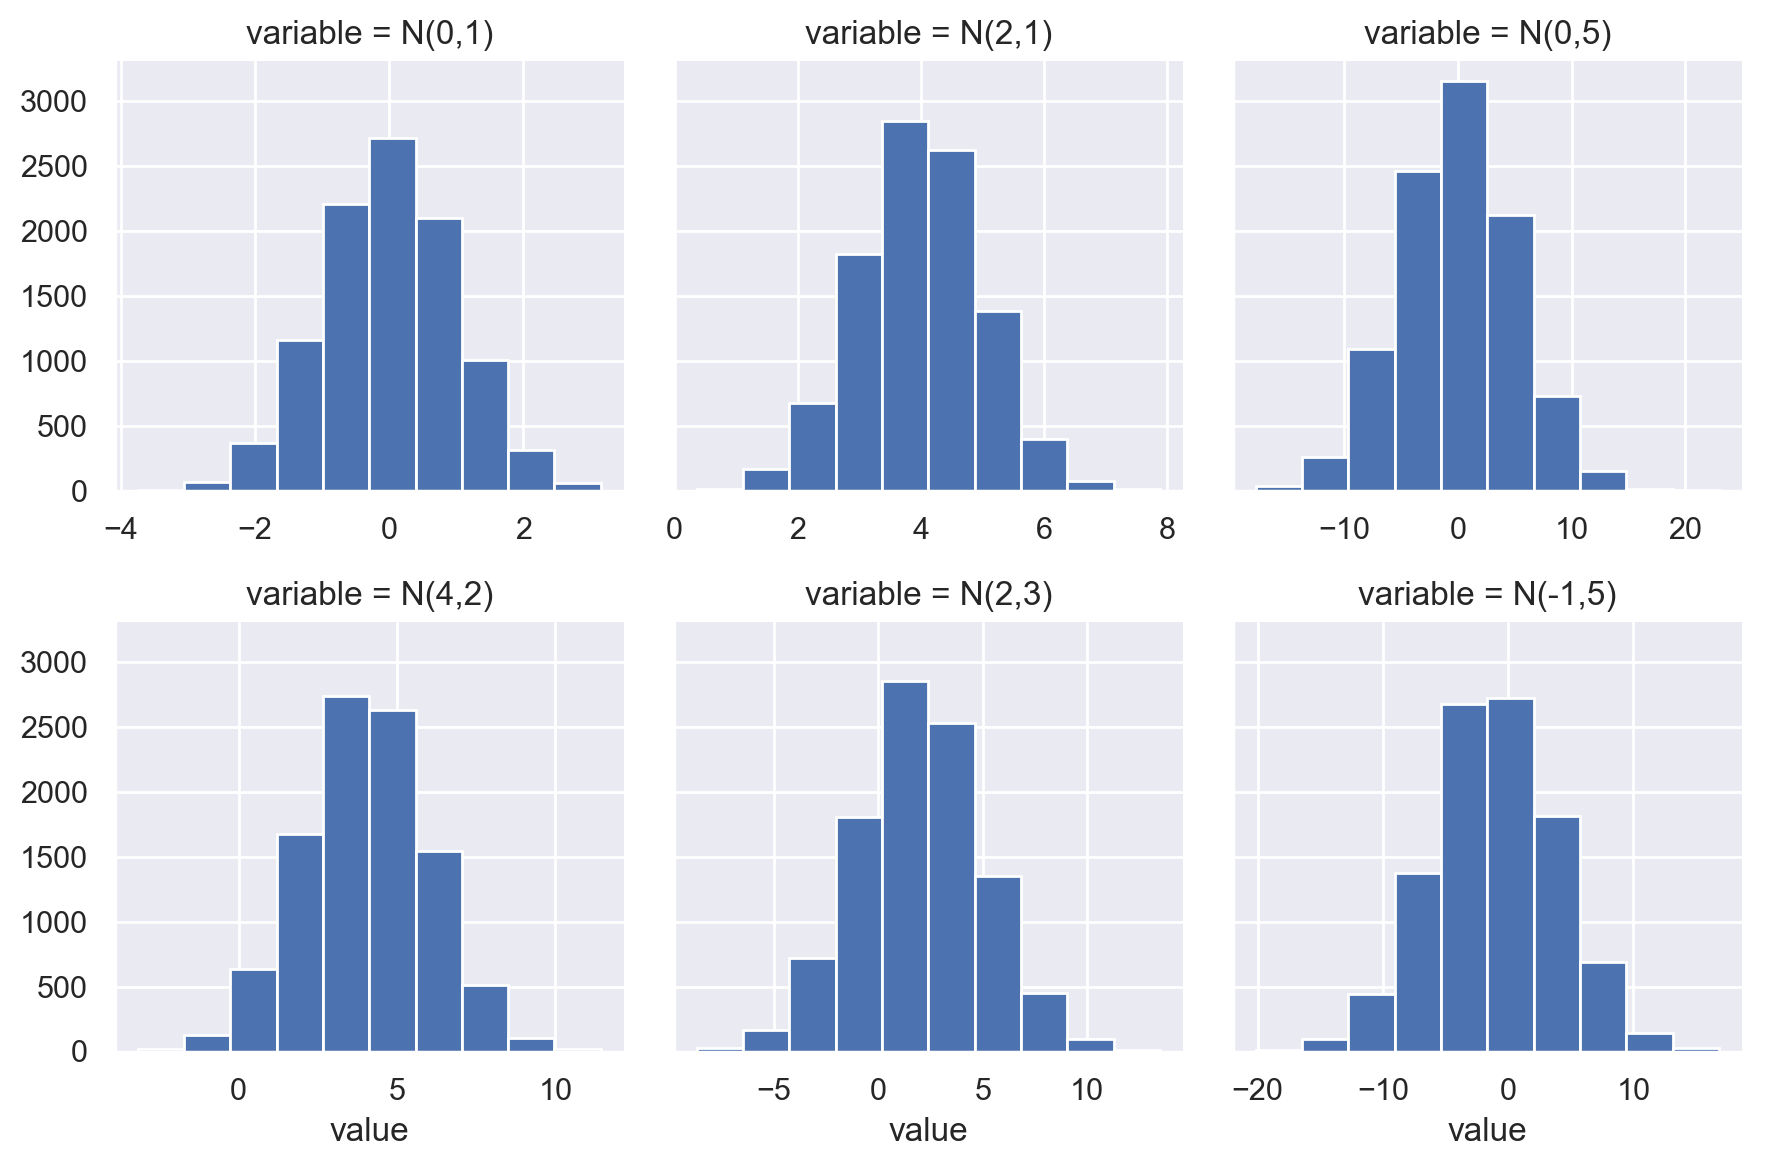

In [63]:
draw(data = df,bins = 10)

### Histograms of normal distribution. Mean affects the postion of the center of the distribution and variance affects the width of it

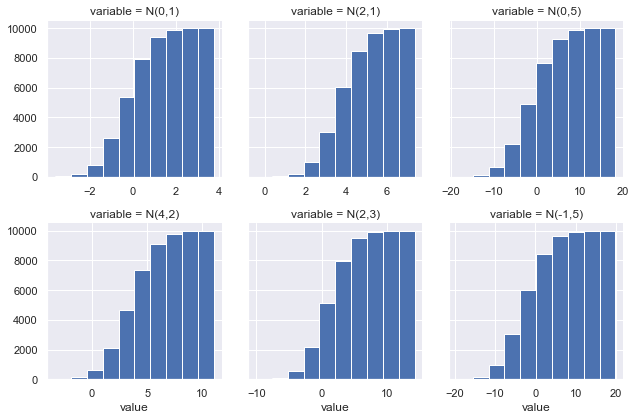

In [17]:
draw(data = df,bins = 10, _cumulative=True)

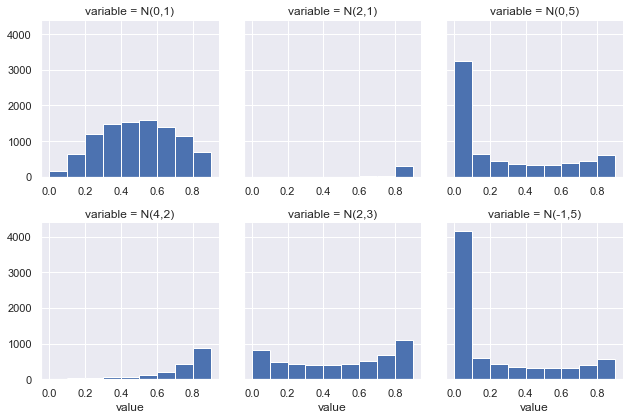

In [18]:
from scipy.special import expit

inv_df = expit(df.sample(size))
draw(inv_df,np.arange(0,1,0.1))

### Inverse logit transformation of normal distribution samples. All the variables are now in [0,1] interval, with high first bin in cases with bigger variance.

In [5]:
poisson_dict = {'poisson(1)': np.random.poisson( 1, size),'poisson(5)': np.random.poisson(5, size),'poisson(2)': np.random.poisson(2, size),
               'poisson(10)': np.random.poisson(10, size),'poisson(3.4)': np.random.poisson(3.4, size),'poisson(0.3)': np.random.poisson(0.3, size)}
poisson_df = pd.DataFrame(poisson_dict)
poisson_df.head(5)

,poisson(1),poisson(5),poisson(2),poisson(10),poisson(3.4),poisson(0.3)
0,1,8,0,10,4,1
1,2,7,0,10,6,1
2,1,10,0,8,3,1
3,0,4,3,8,2,0
4,1,3,2,6,2,0


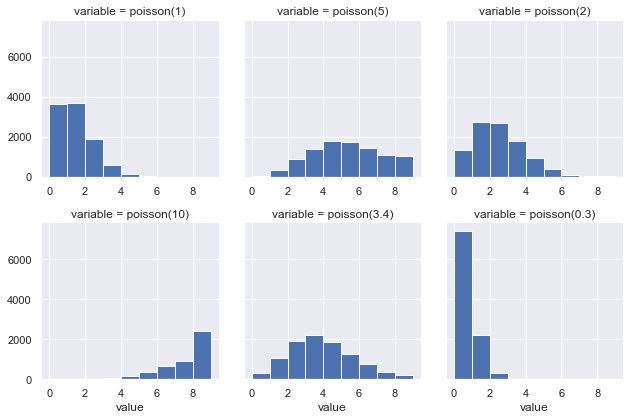

In [6]:
draw(poisson_df,bins = np.arange(0,10,1))

### Poison distribution. All the variables are integers, with highest concentration around $\lambda$

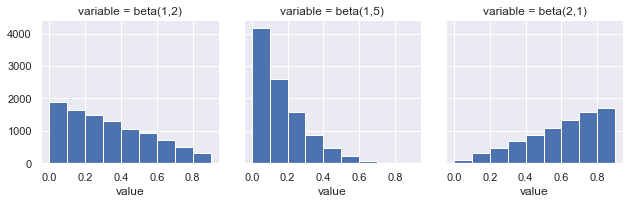

In [21]:
beta_dict = {'beta(1,2)': np.random.beta(1, 2, 10000),'beta(1,5)': np.random.beta(1,5, 10000),'beta(2,1)': np.random.beta(2, 1, 10000)}
beta_df = pd.DataFrame(beta_dict)
beta_df.head(5)
draw(beta_df,bins = np.arange(0,1,0.1))

### Beta distribution for normal parametrization. Values are between 0 and 1.  The shape of distribution is inversed for $\alpha$ > $\beta$

In [1]:
def location(alpha, beta):
    return alpha / (alpha + beta)
def dispersion(alpha, beta):
    temp = location(alpha, beta)
    return temp * (1 - temp) * (1/(alpha + beta + 1))

def mean (alpha, beta):
    return alpha / (alpha + beta)
def population (alpha, beta):
    return (alpha + beta)

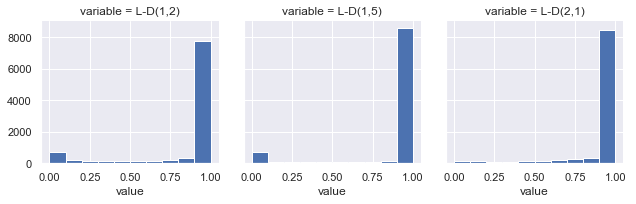

In [23]:
loc_dis = {
    'L-D(1,2)':np.random.beta(location(1,2), dispersion(1,2), size),
    'L-D(1,5)':np.random.beta(location(1,5), dispersion(1,5), size),
    'L-D(2,1)':np.random.beta(location(2,1), dispersion(2,1), size)}

loc_dis_df = pd.DataFrame(loc_dis)
draw(loc_dis_df, np.arange(0,1.1,0.1))

### Beta distribution in location-dispertion parametrzation (with the same $\alpha$, $\beta$ as above)

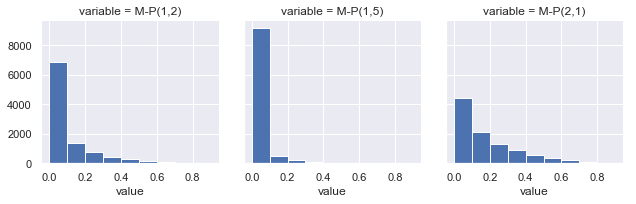

In [24]:
mean_pop = {
    'M-P(1,2)':np.random.beta(mean(1,2), population(1,2), size),
    'M-P(1,5)':np.random.beta(mean(1,5), population(1,5), size),
    'M-P(2,1)':np.random.beta(mean(2,1), population(2,1), size)}

mean_pop_df = pd.DataFrame(mean_pop)
draw(mean_pop_df, np.arange(0,1,0.1))

### Beta distribution in mean-population parametrzation (with the same $\alpha$, $\beta$ as above)

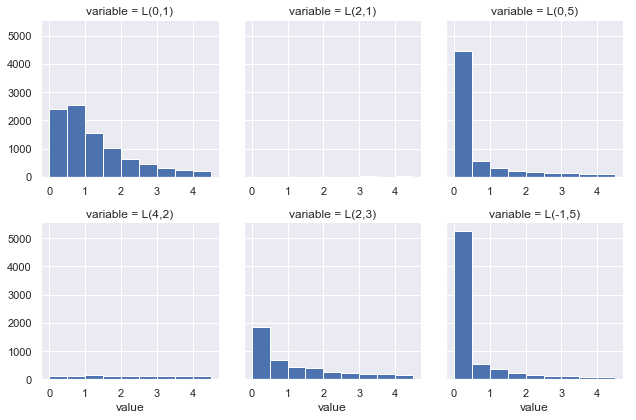

In [14]:
lognormal = {'L(0,1)':np.random.lognormal(0,1,size),'L(2,1)':np.random.lognormal(4,1,size),'L(0,5)':np.random.lognormal(0,5,size),
       'L(4,2)':np.random.lognormal(4,2,size),'L(2,3)':np.random.lognormal(2,3,size),'L(-1,5)':np.random.lognormal(-1,5,size)}

lognormal_df = pd.DataFrame(lognormal)
draw(lognormal_df, np.arange(0,5,0.5))

### Log-normal distribution. Again, we can observe highest first bin for distributions with higher variance. Distributions with variance smaller than mean are very low.